# Load Data

In [2]:
import json
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch import nn
import numpy as np
from scipy.linalg import inv
from torch.optim import Adam

In [3]:
# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]


# Encode Labels

In [4]:
label_encoder = LabelEncoder()
# Fit the label encoder and transform labels to integers
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.fit_transform(val_labels)

# Tokenize our sentences and create Dataloaders

In [5]:
pretrained_model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
transformer_model = AutoModel.from_pretrained(pretrained_model_name)

class TextDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(sentences, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Create the dataset
max_length = 37 
train_dataset = TextDataset(train_sentences, encoded_train_labels, tokenizer, max_length)
val_dataset = TextDataset(val_sentences, encoded_val_labels, tokenizer, max_length)

# Define functions to encode our sentences

In [6]:
transformer_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = transformer_model.to(device)
def encode_sentences(model, sentences):
    sentence_embeddings = []

    for sentence in sentences:
        encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}  # Move input to GPU if available
        with torch.no_grad():
            model_output = model(**encoded_input)

        pooled_output = model_output.last_hidden_state.mean(dim=1)
        sentence_embeddings.append(pooled_output.cpu().numpy())

    sentence_embeddings_np = np.concatenate(sentence_embeddings, axis=0)
    return sentence_embeddings_np

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# ReconstructionLoss

In [9]:
class ReconstructionLoss(nn.Module):
    def __init__(self):
        super(ReconstructionLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, original_embeddings, reconstructed_embeddings):
        return self.mse_loss(original_embeddings, reconstructed_embeddings)

# Define our model

In [8]:
transformer_model = AutoModel.from_pretrained(pretrained_model_name)

class FusedTextClassifier(nn.Module):
    def __init__(self, transformer_model, num_labels):
        super(FusedTextClassifier, self).__init__()
        self.transformer = transformer_model

        # Autoencoder layers
        self.encoder1 = nn.Linear(768, 512)
        self.encoder2 = nn.Linear(512, 64)
        self.encoder3 = nn.Linear(64, 16)
        self.decoder1 = nn.Linear(16, 64)
        self.decoder2 = nn.Linear(64, 512)
        self.decoder3 = nn.Linear(512, 768)

        # Classifier layer
        self.classifier = nn.Linear(768, num_labels)
        self.classifier_enabled = True

    def forward(self, input_ids, attention_mask):
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        sentence_embedding = transformer_output.last_hidden_state.max(dim=1).values

        if self.classifier_enabled:
            # When classifier is enabled, use the output of the transformer directly
            return self.classifier(sentence_embedding)
        else:
            # Autoencoder forward pass
            x = nn.functional.tanh(self.encoder1(sentence_embedding))
            x = nn.functional.tanh(self.encoder2(x))
            x = nn.functional.tanh(self.encoder3(x))

            x = nn.functional.tanh(self.decoder1(x))
            x = nn.functional.tanh(self.decoder2(x))
            reconstructed_embeddings = self.decoder3(x)

            return sentence_embedding, reconstructed_embeddings

    def enable_classifier(self):
        self.classifier_enabled = True

    def disable_classifier(self):
        self.classifier_enabled = False




# Initiallize everything else we needed

In [11]:
pretrained_model_name = "distilroberta-base"
unique_intents = list(set(train_labels)) 
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
transformer_model.to(device)
model = FusedTextClassifier(transformer_model, len(unique_intents))
model.to(device)
optimizer = Adam(model.parameters(), lr=2.2497695787641236e-05)
training_losses = []
validation_losses = []
batch_size= 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
ce_loss = nn.CrossEntropyLoss()
reconstruction_loss = ReconstructionLoss()

In [12]:
num_epochs = 24

# Training Loop!!!

In [20]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    is_classifier_training = epoch % 2 == 0

    # Enable or disable classifier based on the current epoch
    model.enable_classifier() if is_classifier_training else model.disable_classifier()

    # Set classifier parameters' requires_grad appropriately
    for param in model.classifier.parameters():
        param.requires_grad = is_classifier_training

    total_train_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()  # Zero the gradients

        if is_classifier_training:
            # Training logic for classifier
            predictions = model(input_ids, attention_mask)  # Forward pass
            loss = ce_loss(predictions, labels)
        else:
            # Training logic for autoencoder
            original_embeddings, reconstructed_embeddings = model(input_ids, attention_mask)
            loss = reconstruction_loss(original_embeddings, reconstructed_embeddings)

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    model.disable_classifier()  # Always disable classifier in validation for autoencoder reconstruction loss
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            original_embeddings, reconstructed_embeddings = model(input_ids, attention_mask)
            loss = reconstruction_loss(original_embeddings, reconstructed_embeddings)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model, 'best_fusion_model.pth')
        print(f"Epoch {epoch+1}/{num_epochs}: Lower validation loss found. Model saved.")

    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.5e}, Validation Loss: {avg_val_loss:.5e}")


Epoch 1/24: Lower validation loss found. Model saved.
Epoch 1/24, Training Loss: 9.04524e-02, Validation Loss: 4.74251e-01
Epoch 2/24: Lower validation loss found. Model saved.
Epoch 2/24, Training Loss: 2.37041e-01, Validation Loss: 7.58151e-02
Epoch 3/24, Training Loss: 8.79954e-02, Validation Loss: 4.60180e-01
Epoch 4/24: Lower validation loss found. Model saved.
Epoch 4/24, Training Loss: 2.23304e-01, Validation Loss: 7.02151e-02
Epoch 5/24, Training Loss: 8.10756e-02, Validation Loss: 4.45752e-01
Epoch 6/24, Training Loss: 2.11907e-01, Validation Loss: 7.75337e-02
Epoch 7/24, Training Loss: 7.54509e-02, Validation Loss: 4.30866e-01
Epoch 8/24, Training Loss: 2.01663e-01, Validation Loss: 8.13416e-02
Epoch 9/24, Training Loss: 6.70430e-02, Validation Loss: 4.06919e-01
Epoch 10/24, Training Loss: 1.86450e-01, Validation Loss: 7.68926e-02
Epoch 11/24, Training Loss: 6.56508e-02, Validation Loss: 3.91277e-01
Epoch 12/24, Training Loss: 1.76605e-01, Validation Loss: 8.07817e-02
Epoch 1

# Calculate means and covariance matrix

In [15]:
fine_model = torch.load("best_fusion_model.pth")
fine_model.eval()  # Put the model in evaluation mode
fine_model.disable_classifier()
fine_model = fine_model.to(device)

In [16]:
def encode_sentences(model, sentences):
    # the mode here is TextClassifier

    encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt', 
                               max_length=max_length)
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    with torch.no_grad():
        model.eval()  # Ensure the model is in evaluation mode
        original_embeddings, reconstructed_embeddings = model(input_ids, attention_mask)
    return original_embeddings.cpu(), reconstructed_embeddings.cpu()

In [17]:
test_org, test_rec = encode_sentences(fine_model, test_sentences)
oos_test_org, oos_test_rec = encode_sentences(fine_model, oos_test_sentences)

In [18]:
test_diffs = torch.mean((test_org - test_rec) ** 2, dim = 1).numpy()
oos_test_diffs = torch.mean((oos_test_org - oos_test_rec) ** 2, dim = 1).numpy()

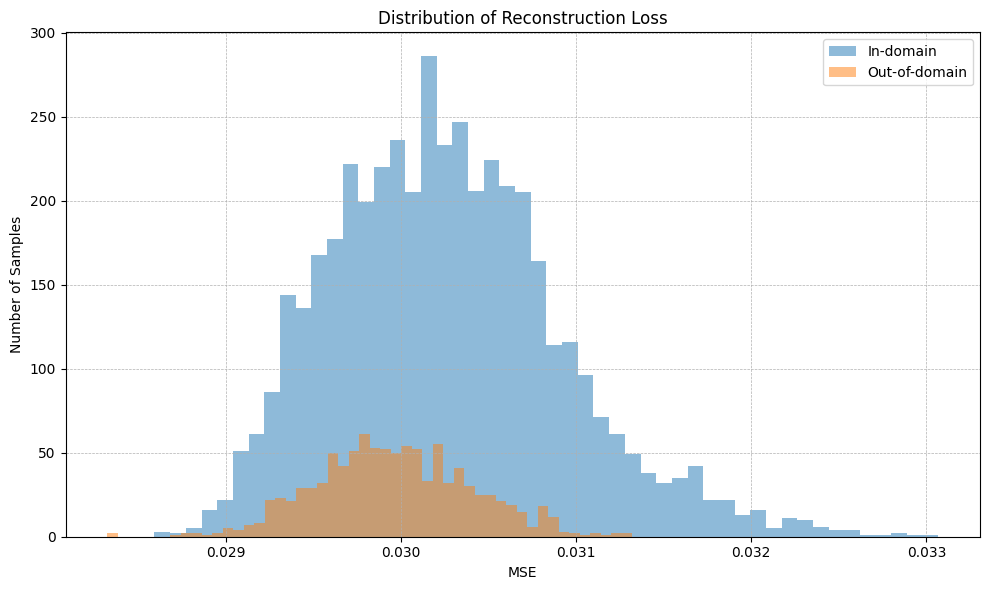

In [19]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_diffs, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_diffs, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Reconstruction Loss')
plt.xlabel('MSE')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()